In [3]:
# =============================================
# 1. Imports & Data Loading
# =============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
import shap
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load data
df = pd.read_csv("Enterprise_GenAI_Adoption_Impact.csv")

# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(df.head())    

# Display the shape of the dataset
print("\nDataset shape:")
print(f"Dataset shape: {df.shape}")     

# Display the data types of each column
print
print(df.dtypes)    

# Display summary statistics of the dataset
print("\nSummary statistics of the dataset:")
print(df.describe())

# Display the number of missing values in each column
print("\nMissing values in each column:") 
print(df.isnull().sum())



First few rows of the dataset:
                              Company Name     Industry       Country  \
0                      Davis LLC Pvt. Ltd.   Healthcare           USA   
1  Roberts, Holland and Bradshaw Pvt. Ltd.      Telecom  South Africa   
2                      Roman Inc Pvt. Ltd.  Advertising         India   
3              Nguyen-Strickland Pvt. Ltd.   Technology            UK   
4                    Jackson PLC Pvt. Ltd.  Hospitality            UK   

  GenAI Tool  Adoption Year  Number of Employees Impacted  New Roles Created  \
0    Mixtral           2022                          5277                  8   
1     Claude           2023                         18762                 17   
2     Gemini           2023                         11307                 17   
3       Groq           2023                         18834                 12   
4      LLaMA           2024                          8364                 22   

   Training Hours Provided  Productivity Change (

In [5]:
# =============================================
# 2. Data Cleaning & Feature Engineering
# =============================================
# Check and impute missing values
for col in ['Industry', 'Country', 'GenAI Tool']:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mode()[0])
for col in ['Productivity Change (%)', 'New Roles Created', 'Number of Employees Impacted', 'Training Hours Provided']:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median())

# Drop rows with missing sentiment (or fill with empty string)
df['Employee Sentiment'] = df['Employee Sentiment'].fillna('')

# Standardize industry/country spelling (optional)
df['Industry'] = df['Industry'].str.strip().str.title()
df['Country'] = df['Country'].str.strip().str.title()

# Feature engineering: job creation rate
df['Job Creation Rate'] = df['New Roles Created'] / (df['Number of Employees Impacted'] + 1)  # add 1 to avoid zero-div

# Feature engineering: year bin (pre/post 2023)
df['Adoption Period'] = np.where(df['Adoption Year'] >= 2023, "Recent", "Earlier")

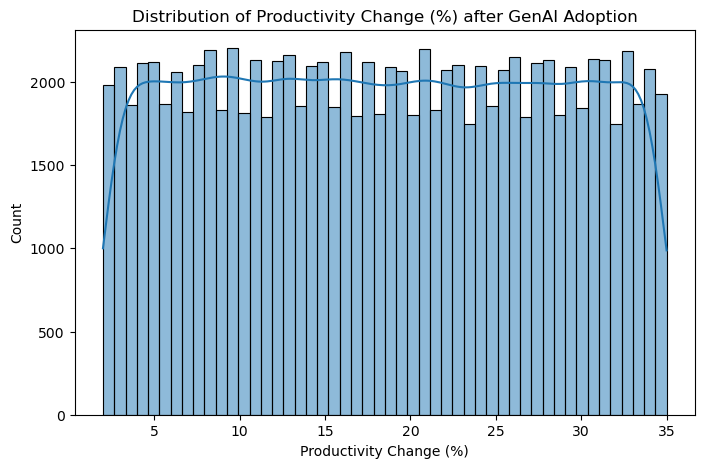

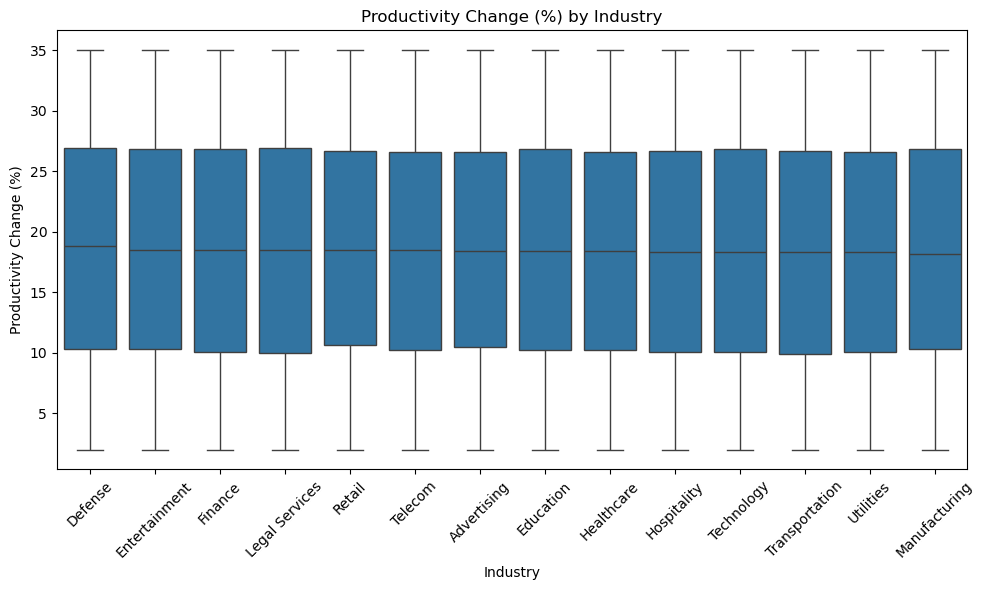

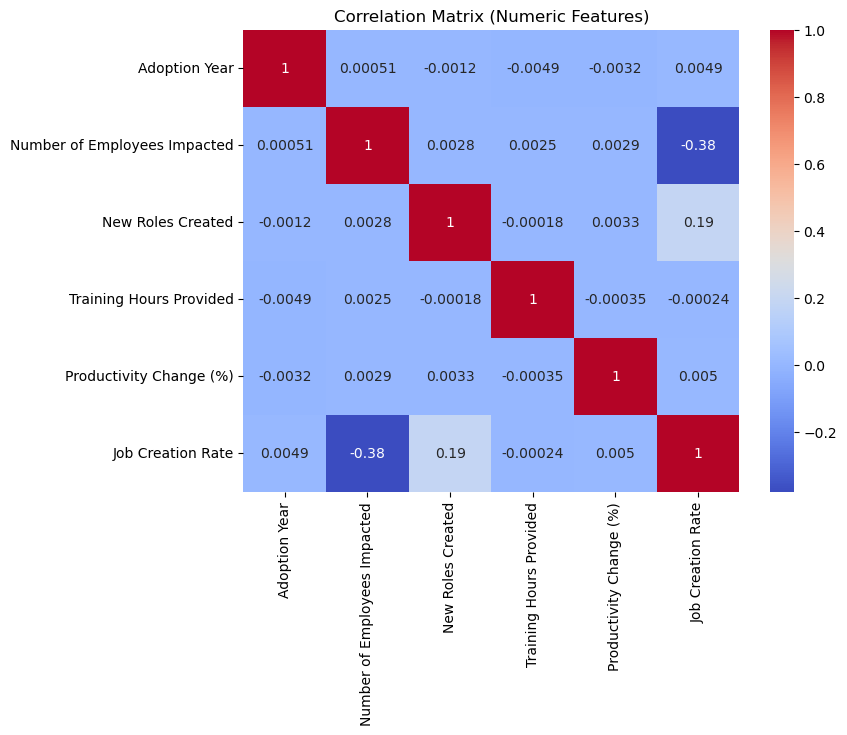

In [6]:
# =============================================
# 3. Exploratory Data Analysis (EDA)
# =============================================
# Histogram: Productivity change
plt.figure(figsize=(8,5))
sns.histplot(df['Productivity Change (%)'], kde=True, bins=50)
plt.title("Distribution of Productivity Change (%) after GenAI Adoption")
plt.xlabel("Productivity Change (%)")
plt.ylabel("Count")
plt.show()

# Boxplot: Productivity by industry
plt.figure(figsize=(10,6))
order = df.groupby('Industry')['Productivity Change (%)'].median().sort_values(ascending=False).index
sns.boxplot(data=df, x='Industry', y='Productivity Change (%)', order=order)
plt.title("Productivity Change (%) by Industry")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation heatmap (numeric)
plt.figure(figsize=(8,6))
corr = df.select_dtypes(include='number').corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix (Numeric Features)")
plt.show()

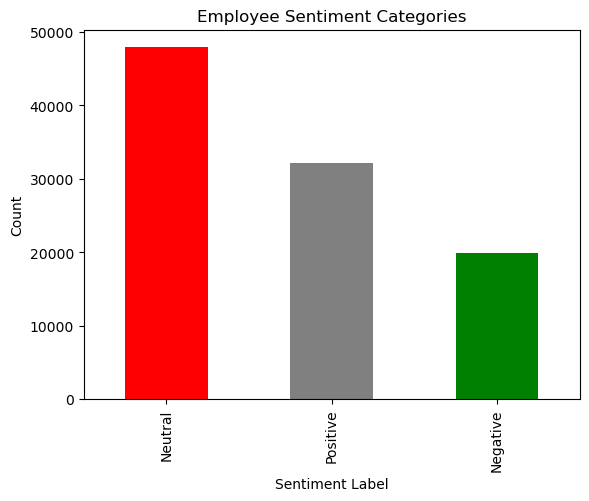

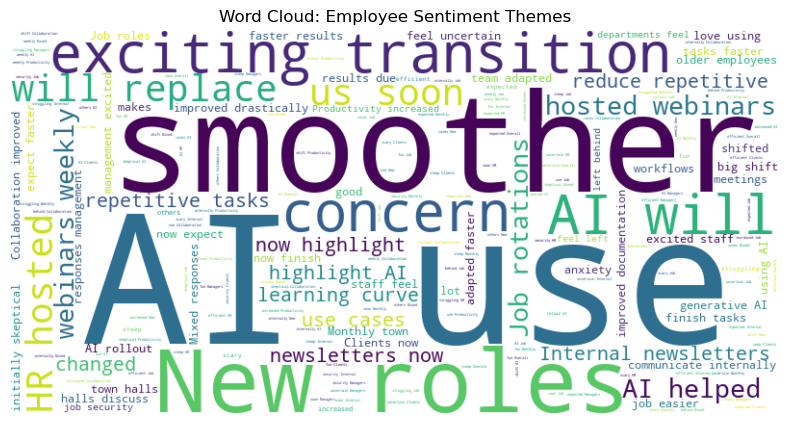

Topic 1:  job, improved, ai, increased, generative, workflows, drastically, meetings
Topic 2:  ai, feel, tasks, job, hr, weekly, hosted, webinars
Topic 3:  ai, faster, use, roles, smoother, expected, transition, exciting


In [7]:
# =============================================
# 4. NLP: Sentiment & Topic Modeling
# =============================================
# Sentiment polarity via TextBlob
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

df['Sentiment Score'] = df['Employee Sentiment'].apply(get_sentiment)
df['Sentiment Label'] = pd.cut(df['Sentiment Score'],
                               bins=[-1.01, -0.1, 0.1, 1.01],
                               labels=['Negative','Neutral','Positive'])

# Sentiment label distribution
sentiment_counts = df['Sentiment Label'].value_counts()
sentiment_counts.plot(kind='bar', color=['red','gray','green'])
plt.title("Employee Sentiment Categories")
plt.ylabel("Count")
plt.show()

# Word cloud of employee sentiment
text = ' '.join(df['Employee Sentiment'].dropna().astype(str).values)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud: Employee Sentiment Themes")
plt.show()

# Topic modeling (LDA) - very basic (for demonstration)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

cv = CountVectorizer(stop_words='english', max_df=0.95, min_df=5)
dtm = cv.fit_transform(df['Employee Sentiment'])
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(dtm)
# Display top words per topic
def display_topics(model, feature_names, no_top_words):
    for ix, topic in enumerate(model.components_):
        print(f"Topic {ix+1}: ", ", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
display_topics(lda, cv.get_feature_names_out(), 8)

In [8]:
# =============================================
# 5. Predictive Modeling (Regression & Classification)
# =============================================
# Encode categoricals
for col in ['Industry', 'Country', 'GenAI Tool', 'Adoption Period']:
    df[col+'_code'] = df[col].astype('category').cat.codes

# --------- Regression: Predict Productivity Change (%) ----------
features_reg = ['Industry_code','Country_code','GenAI Tool_code','Adoption Year','Number of Employees Impacted',
                'New Roles Created','Training Hours Provided','Job Creation Rate']
X_reg = df[features_reg]
y_reg = df['Productivity Change (%)']

X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
reg_rf = RandomForestRegressor(n_estimators=100, random_state=42)
reg_rf.fit(X_train, y_train)
y_pred = reg_rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Random Forest Regression MAE: {mae:.2f}, RMSE: {rmse:.2f}")

Random Forest Regression MAE: 8.36, RMSE: 9.72


In [9]:
# XGBoost Regression (more advanced)
reg_xgb = xgb.XGBRegressor(n_estimators=100, random_state=42)
reg_xgb.fit(X_train, y_train)
y_pred_xgb = reg_xgb.predict(X_test)
print(f"XGBoost Regression RMSE: {mean_squared_error(y_test, y_pred_xgb, squared=False):.2f}")

XGBoost Regression RMSE: 9.69


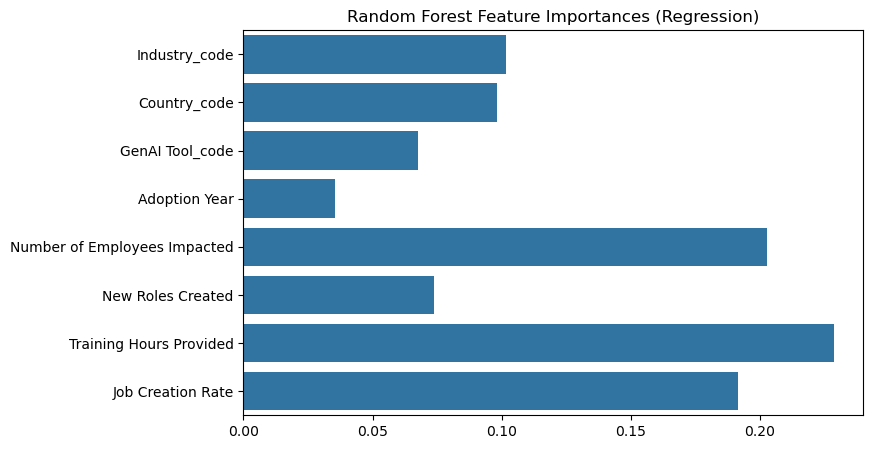

In [10]:
# Feature importances
plt.figure(figsize=(8,5))
sns.barplot(x=reg_rf.feature_importances_, y=features_reg)
plt.title("Random Forest Feature Importances (Regression)")
plt.show()

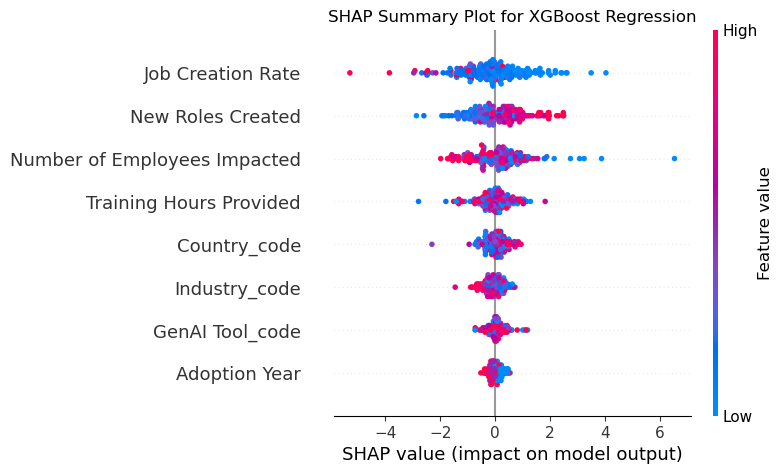

In [11]:
# SHAP Explainability (for XGBoost)
explainer = shap.Explainer(reg_xgb, X_train)
shap_values = explainer(X_test[:200]) # Use a small sample for speed
shap.summary_plot(shap_values, X_test[:200], show=False)
plt.title("SHAP Summary Plot for XGBoost Regression")
plt.show()

Random Forest Classification Accuracy: 0.7525
Random Forest ROC-AUC: 0.4941805659905241


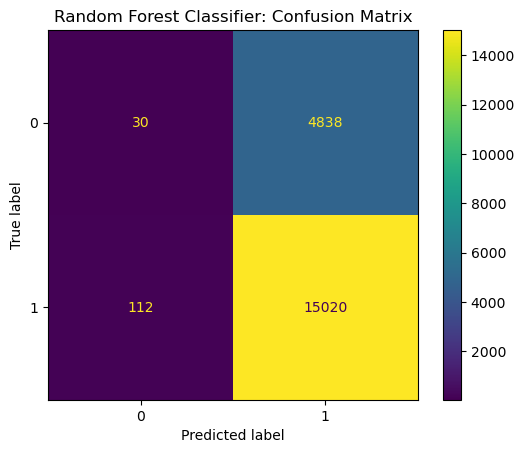

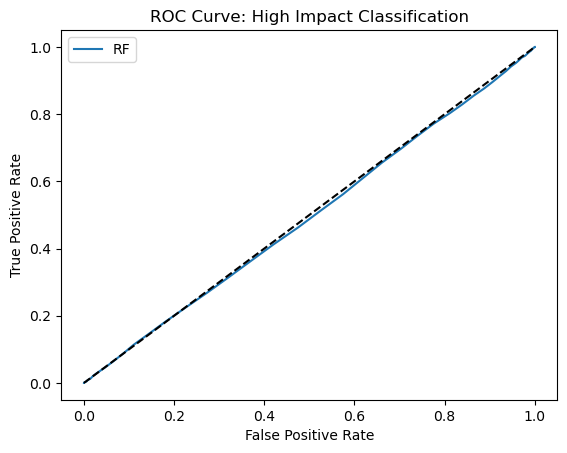

In [12]:
# --------- Classification: High Impact (Productivity > 10%) ----------
df['High Impact'] = (df['Productivity Change (%)'] > 10).astype(int)
features_cls = features_reg
X_cls = df[features_cls]
y_cls = df['High Impact']

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train_cls, y_train_cls)
y_pred_cls = clf_rf.predict(X_test_cls)
print("Random Forest Classification Accuracy:", accuracy_score(y_test_cls, y_pred_cls))
print("Random Forest ROC-AUC:", roc_auc_score(y_test_cls, clf_rf.predict_proba(X_test_cls)[:,1]))

# Confusion matrix
cm = confusion_matrix(y_test_cls, y_pred_cls)
ConfusionMatrixDisplay(cm).plot()
plt.title("Random Forest Classifier: Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_cls, clf_rf.predict_proba(X_test_cls)[:,1])
plt.plot(fpr, tpr, label='RF')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: High Impact Classification")
plt.legend()
plt.show()

In [13]:
# XGBoost Classifier with GridSearchCV for Hyperparameter Tuning
from sklearn.model_selection import StratifiedKFold
clf_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param_grid = {'n_estimators': [100, 200], 'max_depth': [3, 5]}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
gs = GridSearchCV(clf_xgb, param_grid, cv=cv, scoring='roc_auc', verbose=1, n_jobs=-1)
gs.fit(X_train_cls, y_train_cls)
print("Best XGBoost Classifier Params:", gs.best_params_)
y_pred_xgb = gs.predict(X_test_cls)
print("XGBoost Classifier Accuracy:", accuracy_score(y_test_cls, y_pred_xgb))
print("XGBoost Classifier ROC-AUC:", roc_auc_score(y_test_cls, gs.predict_proba(X_test_cls)[:,1]))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best XGBoost Classifier Params: {'max_depth': 3, 'n_estimators': 200}
XGBoost Classifier Accuracy: 0.75615
XGBoost Classifier ROC-AUC: 0.4882237284235078


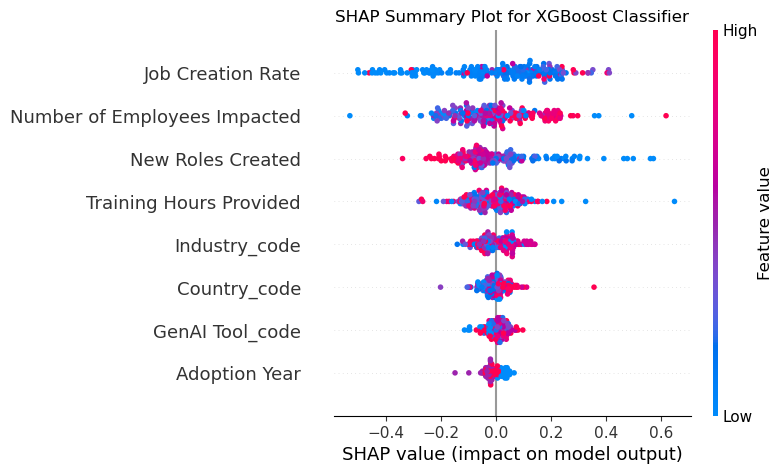

In [14]:
# SHAP for XGBoost Classifier
explainer_cls = shap.Explainer(gs.best_estimator_, X_train_cls)
shap_values_cls = explainer_cls(X_test_cls[:200])
shap.summary_plot(shap_values_cls, X_test_cls[:200], show=False)
plt.title("SHAP Summary Plot for XGBoost Classifier")
plt.show()

In [15]:
# Cross-validation scores for model robustness
rf_scores = cross_val_score(clf_rf, X_cls, y_cls, cv=5, scoring='roc_auc')
print(f"Random Forest Classifier Mean ROC-AUC (5-fold): {rf_scores.mean():.3f}")

Random Forest Classifier Mean ROC-AUC (5-fold): 0.501


In [16]:
# =============================================
# 6. Save Results/Artifacts 
# =============================================
# Save models or plots if needed for reporting
# import joblib
# joblib.dump(reg_rf, 'rf_reg_model.pkl')
# joblib.dump(clf_rf, 'rf_cls_model.pkl')

print("Full analysis complete. See plots and console outputs for insights.")


Full analysis complete. See plots and console outputs for insights.
